<a href="https://colab.research.google.com/github/Thiru2208/CM2607_CW/blob/main/2425449_20241152_CM2607_CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from numpy.fft import rfft, rfftfreq
import cv2

# 1. Modelling Travel Time

In [ ]:
#Define Symbols
x, y = sp.symbols('x y', positive = True, real = True)
a, b, c = sp.symbols ('a  b c', positive = True, real = True)

#Travel time modela
Tb = a*x**2 + b*y**2
Tt = sp.sqrt(c*(x**2 + y**2))

Tb, Tt

(a*x**2 + b*y**2, sqrt(c)*sqrt(x**2 + y**2))

In [ ]:
# Compute gradients
dTb_dx = sp.diff(Tb, x)
dTb_dy = sp.diff(Tb, y)
dTt_dx = sp.diff(Tt, x)
dTt_dy = sp.diff(Tt, y)

grad_Tb = (sp.simplify(dTb_dx), sp.simplify(dTb_dy))
grad_Tt = (sp.simplify(dTt_dx), sp.simplify(dTt_dy))

print("Gradient for bus is ",grad_Tb)
print("Gradient for Taxi is ",grad_Tt)

Gradient for bus is  (2*a*x, 2*b*y)
Gradient for Taxi is  (sqrt(c)*x/sqrt(x**2 + y**2), sqrt(c)*y/sqrt(x**2 + y**2))


In [ ]:
# NOTE: a0, b0, c0 are assumed parameter values for illustration

In [ ]:
# ----- Numeric evaluation helper -----
x0 = 4.5  # given route distance (approx)

a0 = 2.0
b0 = 1.0
c0 = 9.0

# Choose a few traffic delay values (min/km)
y_values = [1, 3, 6]

# Substitute and evaluate partial derivatives at (x0, y)
for y0 in y_values:
    bus_dx = float(dTb_dx.subs({a:a0, x:x0}))
    bus_dy = float(dTb_dy.subs({b:b0, y:y0}))

    taxi_dx = float(dTt_dx.subs({c:c0, x:x0, y:y0}))
    taxi_dy = float(dTt_dy.subs({c:c0, x:x0, y:y0}))

    print(f"\nAt x={x0} km, y={y0} min/km")
    print(f"Bus:  ∂Tb/∂x = {bus_dx:.3f},  ∂Tb/∂y = {bus_dy:.3f}")
    print(f"Taxi: ∂Tt/∂x = {taxi_dx:.3f},  ∂Tt/∂y = {taxi_dy:.3f}")



At x=4.5 km, y=1 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 2.000
Taxi: ∂Tt/∂x = 2.929,  ∂Tt/∂y = 0.651

At x=4.5 km, y=3 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 6.000
Taxi: ∂Tt/∂x = 2.496,  ∂Tt/∂y = 1.664

At x=4.5 km, y=6 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 12.000
Taxi: ∂Tt/∂x = 1.800,  ∂Tt/∂y = 2.400


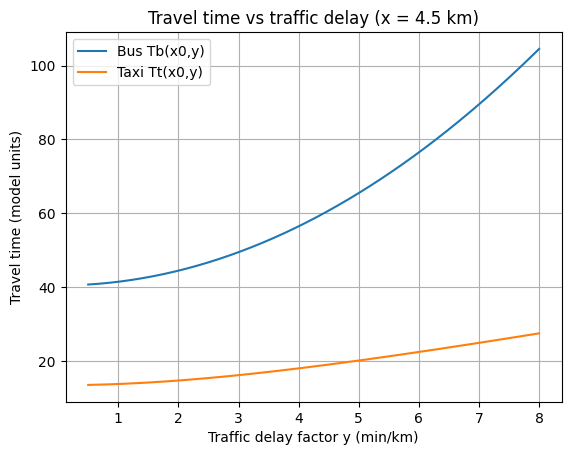

In [ ]:
ys = np.linspace(0.5, 8.0, 250)

Tb_num = a0*(x0**2) + b0*(ys**2)
Tt_num = np.sqrt(c0*((x0**2) + (ys**2)))

plt.figure()
plt.plot(ys, Tb_num, label="Bus Tb(x0,y)")
plt.plot(ys, Tt_num, label="Taxi Tt(x0,y)")
plt.xlabel("Traffic delay factor y (min/km)")
plt.ylabel("Travel time (model units)")
plt.title("Travel time vs traffic delay (x = 4.5 km)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print("For the bus model, sensitivity to distance is 2ax (so it increases with distance), "
"and sensitivity to traffic is 2by (so it increases with traffic delay).")
print("This means that under light traffic, distance contributes more to the bus travel time, but as congestion increases, the term 2*b*y becomes dominant, making traffic delay the stronger factor.")
print("For the taxi model Tt = sqrt(c*(x^2 + y^2)), the gradient distributes the influence of distance and delay through the common denominator sqrt(x^2 + y^2).")
print("When traffic delay is small, both distance and delay contribute similarly, but as y grows larger, the sensitivity dTt/dy overtakes dTt/dx.")
print("Therefore, taxi travel time becomes increasingly influenced by heavy traffic, showing that congestion affects both modes but impacts the bus more sharply at high delay levels.")

For the bus model, sensitivity to distance is 2ax (so it increases with distance), and sensitivity to traffic is 2by (so it increases with traffic delay).
This means that under light traffic, distance contributes more to the bus travel time, but as congestion increases, the term 2*b*y becomes dominant, making traffic delay the stronger factor.
For the taxi model Tt = sqrt(c*(x^2 + y^2)), the gradient distributes the influence of distance and delay through the common denominator sqrt(x^2 + y^2).
When traffic delay is small, both distance and delay contribute similarly, but as y grows larger, the sensitivity dTt/dy overtakes dTt/dx.
Therefore, taxi travel time becomes increasingly influenced by heavy traffic, showing that congestion affects both modes but impacts the bus more sharply at high delay levels.


# 2. Cost Analysis Using Integration

In [ ]:
#Symbolic Integration

# Define symbols
t = sp.symbols('t', real=True)
x_sym = sp.symbols('x', nonnegative=True, real=True)

# Cost-rate functions
rate_bus = 2*t + 1
rate_taxi = 3*t + 2

# Integrate from 0 to x
Fb_expr = sp.integrate(rate_bus, (t, 0, x_sym))
Ft_expr = sp.integrate(rate_taxi, (t, 0, x_sym))

print("Fb(x) =", Fb_expr)
print("Ft(x) =", Ft_expr)

Fb(x) = x**2 + x
Ft(x) = 3*x**2/2 + 2*x


In [ ]:
# Convert symbolic expressions into numeric functions
Fb = sp.lambdify(x_sym, Fb_expr, 'numpy')
Ft = sp.lambdify(x_sym, Ft_expr, 'numpy')


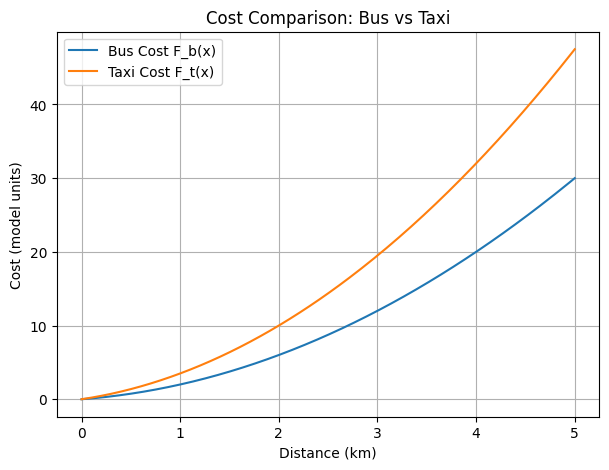

In [ ]:
# Distance values 0–5 km
xs = np.linspace(0, 5, 200)

plt.figure(figsize=(7,5))
plt.plot(xs, Fb(xs), label="Bus Cost F_b(x)")
plt.plot(xs, Ft(xs), label="Taxi Cost F_t(x)")
plt.xlabel("Distance (km)")
plt.ylabel("Cost (model units)")
plt.title("Cost Comparison: Bus vs Taxi")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print("""When we look at the integrated cost functions for the bus and taxi, the bus cost
Fb(x) = x + x^2
grows more slowly because both the linear and quadratic parts are smaller. The taxi cost
Ft(x) = 2x + 3/2 x^2
increases faster, since it starts with a higher basic rate and its squared term also has
a bigger coefficient. For short distances, the difference between the two costs isn’t very
large, but as the distance increases, the taxi price rises much more quickly than the bus price.
This shows that the bus remains the cheaper option overall, especially for longer trips, because
the cost growth is slower compared to the taxi.
""")

When we look at the integrated cost functions for the bus and taxi, the bus cost
Fb(x) = x + x^2
grows more slowly because both the linear and quadratic parts are smaller. The taxi cost
Ft(x) = 2x + 3/2 x^2
increases faster, since it starts with a higher basic rate and its squared term also has
a bigger coefficient. For short distances, the difference between the two costs isn’t very
large, but as the distance increases, the taxi price rises much more quickly than the bus price.
This shows that the bus remains the cheaper option overall, especially for longer trips, because
the cost growth is slower compared to the taxi.



# 3. Predicting Peak Travel Times Using Series Convergence

In [5]:
# Series approximation of P(t) using FIRST 4 NON-ZERO TERMS

t = sp.symbols("t", real=True)

P = 5 + 4*sp.sin(sp.pi*t) - sp.Rational(3,2)*t**2 + sp.Rational(1,4)*t**4

In [6]:
# Expand enough order, then keep first 4 non-zero terms
Pser = sp.series(P, t, 0, 8).removeO().expand()

terms = sp.Add.make_args(Pser)  # split into terms
terms_sorted = sorted(terms, key=lambda expr: sp.degree(expr, t))  # by power of t
P_4 = sp.Add(*terms_sorted[:4])  # first 4 terms

In [7]:
P_4_s = sp.simplify(P_4)
P_4_s

-2*pi**3*t**3/3 - 3*t**2/2 + 4*pi*t + 5

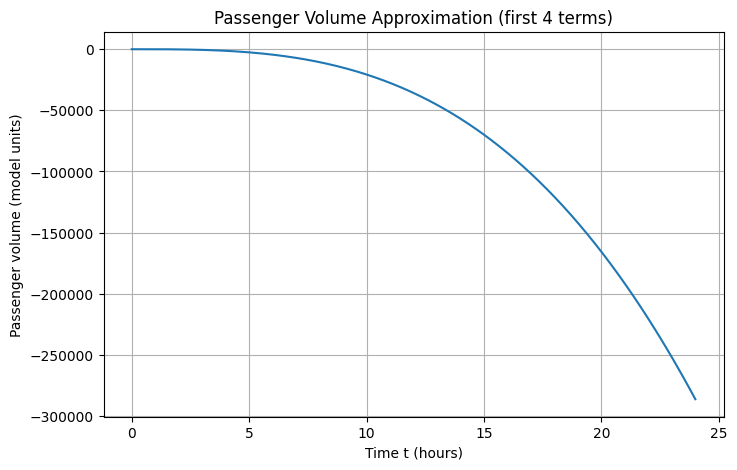

t=0.43 h, P=8.482
t=0.38 h, P=8.436
t=0.48 h, P=8.397
t=0.34 h, P=8.272
t=0.53 h, P=8.167


In [12]:
P_func = sp.lambdify(t, P_4_s, 'numpy')

ts = np.linspace(0, 24, 500)
vals = P_func(ts)

plt.figure(figsize=(8,5))
plt.plot(ts, vals)
plt.xlabel("Time t (hours)")
plt.ylabel("Passenger volume (model units)")
plt.title("Passenger Volume Approximation (first 4 terms)")
plt.grid(True)
plt.show()

#Peack travel periods
k = 5
top_idx = np.argsort(vals)[-k:][::-1]
for i in top_idx:
    print(f"t={ts[i]:.2f} h, P={vals[i]:.3f}")


In [ ]:
print("The Taylor series approximation is taken about t = 0; therefore, accuracy reduces as t moves farther away from 0.")

The Taylor series approximation is taken about t = 0; therefore, accuracy reduces as t moves farther away from 0.


# 4. Travel Pattern Analysis Using Fourier Transform

In [ ]:
# Time settings: 6 AM to 9 PM, every 5 minutes
dt = 5  # minutes
time_hours = np.arange(6, 21, dt/60)

# Simulated boarding counts (morning + evening peaks)
bus_counts = (
    40
    + 35*np.exp(-0.5*((time_hours-8)/0.8)**2)
    + 45*np.exp(-0.5*((time_hours-17.5)/1.0)**2)
)

taxi_counts = (
    30
    + 25*np.exp(-0.5*((time_hours-8.5)/0.9)**2)
    + 30*np.exp(-0.5*((time_hours-18)/1.1)**2)
)

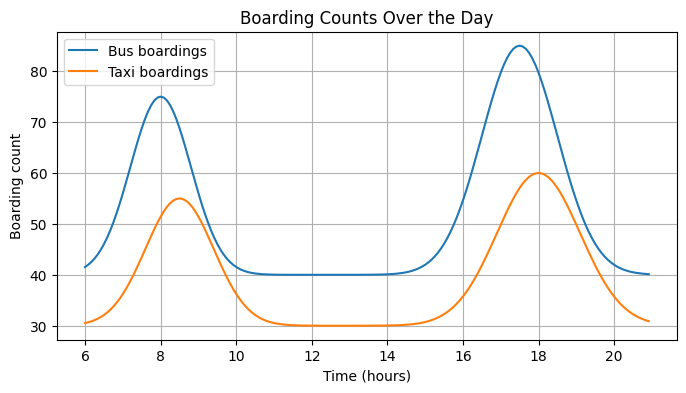

In [ ]:
# Plot original signals
plt.figure(figsize=(8,4))
plt.plot(time_hours, bus_counts, label="Bus boardings")
plt.plot(time_hours, taxi_counts, label="Taxi boardings")
plt.xlabel("Time (hours)")
plt.ylabel("Boarding count")
plt.title("Boarding Counts Over the Day")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Remove mean (important for FFT)
bus_detrended = bus_counts - np.mean(bus_counts)
taxi_detrended = taxi_counts - np.mean(taxi_counts)

# Fourier Transform
bus_fft = np.abs(rfft(bus_detrended))
taxi_fft = np.abs(rfft(taxi_detrended))

# Frequency axis (cycles per hour)
freqs = rfftfreq(len(bus_counts), d=dt/60)

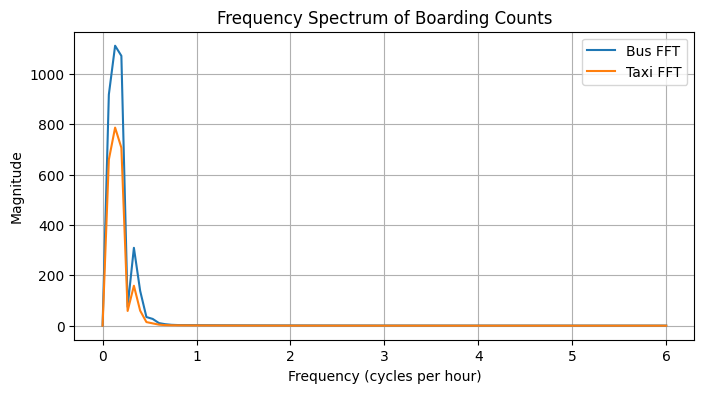

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(freqs, bus_fft, label="Bus FFT")
plt.plot(freqs, taxi_fft, label="Taxi FFT")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum of Boarding Counts")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Ignore zero-frequency (mean)
bus_fft_no0 = bus_fft.copy()
bus_fft_no0[0] = 0

taxi_fft_no0 = taxi_fft.copy()
taxi_fft_no0[0] = 0

bus_peak_freq = freqs[np.argmax(bus_fft_no0)]
taxi_peak_freq = freqs[np.argmax(taxi_fft_no0)]

bus_peak_freq, taxi_peak_freq

(np.float64(0.13333333333333333), np.float64(0.13333333333333333))



*   The boarding count plots show two clear peak periods during the day, one in the morning and another in the evening, which correspond to typical commuting hours.

*   After applying the Fourier Transform, the dominant frequency for both bus and taxi boarding data is approximately 0.133 cycles per hour.

*  This dominant frequency corresponds to a repeating pattern with a period of about 7.5 hours, indicating regular daily travel demand cycles.

*   The presence of the same dominant frequency for buses and taxis suggests that both transport modes follow similar daily usage patterns.

*   However, the magnitude of the bus Fourier components is higher, showing that buses carry a larger number of passengers compared to taxis.

*  Overall, the Fourier analysis successfully identifies peak travel periods and demonstrates how frequency‑domain methods can support transport planning and scheduling.












# 5. Image Processing Using Fourier and Discrete Cosine Transforms


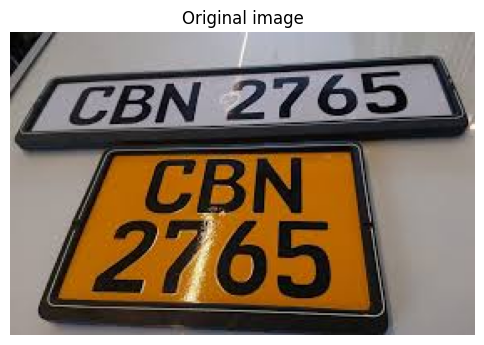

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("/content/vehicle_plate.png")
if img is None:
    raise FileNotFoundError("vehicle_plate.png not found. Upload it to Colab Files.")

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original image")
plt.axis("off")
plt.show()

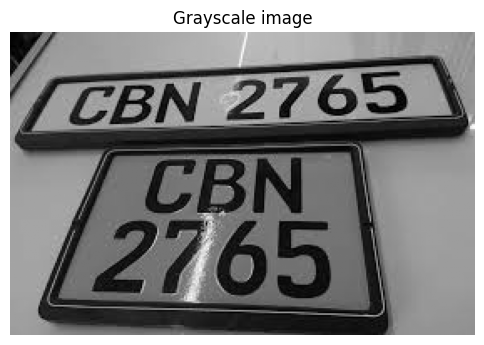

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6,4))
plt.imshow(gray, cmap="gray")
plt.title("Grayscale image")
plt.axis("off")
plt.show()

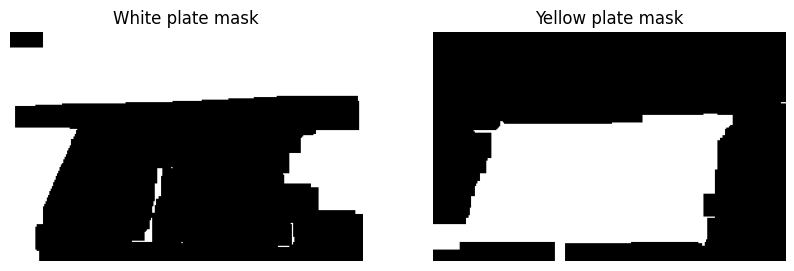

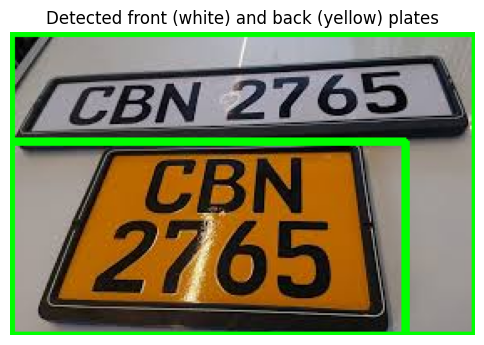

In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Front plate (white): low saturation + high brightness
white_mask = cv2.inRange(hsv, (0, 0, 160), (180, 70, 255))

# Back plate (yellow): hue range for yellow (tune if needed)
yellow_mask = cv2.inRange(hsv, (10, 40, 60), (55, 255, 255))

# Clean masks
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 9))
white_clean  = cv2.morphologyEx(white_mask,  cv2.MORPH_CLOSE, kernel, iterations=2)
yellow_clean = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Show masks (important for debugging)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(white_clean, cmap="gray");  plt.title("White plate mask");  plt.axis("off")
plt.subplot(1,2,2); plt.imshow(yellow_clean, cmap="gray"); plt.title("Yellow plate mask"); plt.axis("off")
plt.show()

def largest_box(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return x, y, w, h

front_box = largest_box(white_clean)   # white = front
back_box  = largest_box(yellow_clean)  # yellow = back

if front_box is None or back_box is None:
    raise ValueError("Plate detection failed. Adjust HSV ranges (yellow/white) based on mask images.")

x1, y1, w1, h1 = front_box
x2, y2, w2, h2 = back_box

# Draw boxes to verify
vis = img.copy()
cv2.rectangle(vis, (x1,y1), (x1+w1, y1+h1), (0,255,0), 3)
cv2.rectangle(vis, (x2,y2), (x2+w2, y2+h2), (0,255,0), 3)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Detected front (white) and back (yellow) plates")
plt.axis("off")
plt.show()

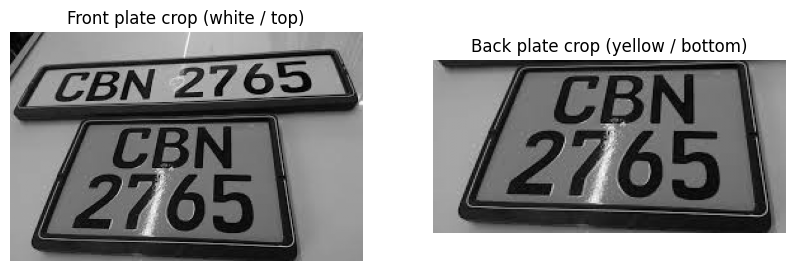

In [ ]:
front_plate = gray[y1:y1+h1, x1:x1+w1]  # top rectangle
back_plate  = gray[y2:y2+h2, x2:x2+w2]  # bottom rectangle

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(front_plate, cmap="gray")
plt.title("Front plate crop (white / top)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(back_plate, cmap="gray")
plt.title("Back plate crop (yellow / bottom)")
plt.axis("off")
plt.show()


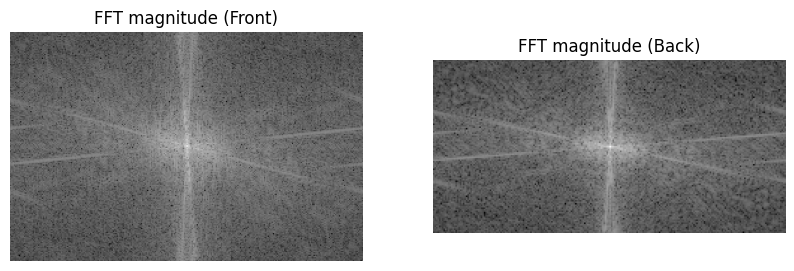

In [ ]:
def fft_magnitude(img_gray):
    F = np.fft.fft2(img_gray)
    F_shifted = np.fft.fftshift(F)
    mag = 20 * np.log(np.abs(F_shifted) + 1)
    return mag

front_fft = fft_magnitude(front_plate)
back_fft  = fft_magnitude(back_plate)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(front_fft, cmap="gray")
plt.title("FFT magnitude (Front)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(back_fft, cmap="gray")
plt.title("FFT magnitude (Back)")
plt.axis("off")
plt.show()


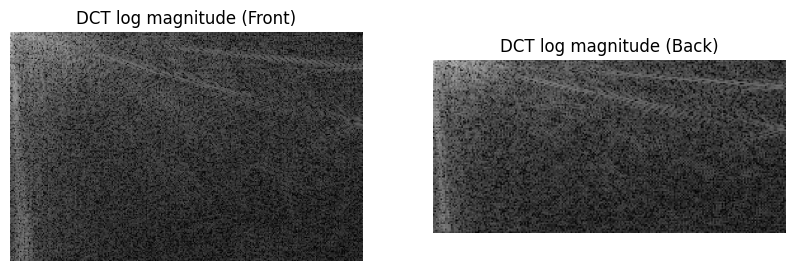

In [ ]:
def dct_log_magnitude(img_gray):
    img_float = np.float32(img_gray)
    D = cv2.dct(img_float)
    return np.log(np.abs(D) + 1)

front_dct = dct_log_magnitude(front_plate)
back_dct  = dct_log_magnitude(back_plate)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(front_dct, cmap="gray")
plt.title("DCT log magnitude (Front)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(back_dct, cmap="gray")
plt.title("DCT log magnitude (Back)")
plt.axis("off")
plt.show()
